**DATA COLLECTION**

In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [0]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (6).json


{'kaggle.json': b'{"username":"shobhit2000","key":"208e95d811f300fc93bdb358e31573d0"}'}

In [0]:
!cp kaggle.json ~/.kaggle/

In [0]:
!kaggle datasets download -d greg115/celebrities-100k

celebrities-100k.zip: Skipping, found more recently modified local copy (use --force to force download)


**IMPORTING LIBRARIES**

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import cv2
import glob
import os
from PIL import Image
from zipfile import ZipFile
from keras.models import Sequential
from keras.layers import UpSampling2D, Dense, Conv2D, Dropout, Flatten, LeakyReLU, ReLU, BatchNormalization, Reshape, MaxPooling2D
from keras.optimizers import SGD
import tensorflow
import pickle

Using TensorFlow backend.


In [0]:
!mkdir data
Pred_img = []

mkdir: cannot create directory ‘data’: File exists


**DATA COLLECTION**

In [0]:
with ZipFile('celebrities-100k.zip', 'r') as obj:
  obj.extractall('data')

In [0]:
!ls data

100k  100k.txt


In [0]:
os.chdir('/content/data/')
images = '/content/data/100k/100k/'
path = '/content/data/100k.txt/'

In [0]:
paths = pd.read_csv('100k.txt', sep=" ", header=None)
paths.columns= ["img_names"]
paths.head()

,img_names
0,000001.jpg
1,000002.jpg
2,000003.jpg
3,000006.jpg
4,000008.jpg


/content/data/100k/100k/009448.jpg


(-0.5, 127.5, 127.5, -0.5)

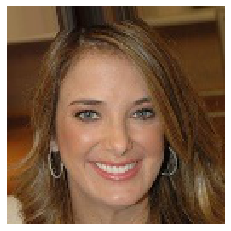

In [0]:
indexed_data = paths.iloc[4700]

location = indexed_data[0]
temp_path = os.path.join(images, location)
print(temp_path)
img = mpimg.imread(temp_path)
plt.imshow(img)
plt.axis('off')

In [0]:
!cd .. 

**PREPARING THE TRAINING DATA**

In [0]:
def dataset():

  '''with ZipFile('celebrities-100k.zip', 'r') as obj:
    obj.extractall('data')

  os.chdir('/content/data/')
  images = '/content/data/100k/100k/'
  path = '/content/data/100k.txt/'  

  paths = pd.read_csv('100k.txt', sep=" ", header=None)
  paths.columns= ["img_names"]
'''
  X_train=[]
  input_dim = 128
  for i in glob.glob('/content/data/100k/100k/*.jpg'):
    img = cv2.imread(i)
    img = cv2.resize(img, (128, 128))
    img = img/255
    X_train.append(img)

  X_train = np.asarray(X_train)
  X_train = X_train[:5000]
  print(X_train.shape)
  return X_train

**GENERATOR MODEL**

In [0]:
def generator_model():
  
  gen_model = Sequential()
  gen_model.add(Dense(512, input_shape=(128,)))
  gen_model.add(LeakyReLU(alpha=0.2))
  
  gen_model.add(Dense(128*8*8))
  gen_model.add(BatchNormalization())
  gen_model.add(LeakyReLU(alpha=0.2))

  gen_model.add(Reshape((8, 8, 128), input_shape = (128 * 8 * 8, )))
  gen_model.add(UpSampling2D(size=(2, 2)))
  gen_model.add(Conv2D(64, (3, 3), padding='same'))
  gen_model.add(LeakyReLU(alpha=0.2))

  gen_model.add(UpSampling2D(size=(4, 4)))
  gen_model.add(Conv2D(32, (3, 3), padding='same'))
  gen_model.add(LeakyReLU(alpha=0.2))

  #gen_model.add(UpSampling2D(size=(2, 2)))
  #gen_model.add(Conv2D(32, (3, 3), padding='same'))
  #gen_model.add(LeakyReLU(alpha=0.2))

  gen_model.add(UpSampling2D(size=(2, 2)))
  gen_model.add(Conv2D(3, (3, 3), padding='same'))
  gen_model.add(ReLU())

  return gen_model

In [0]:
def discriminator_model():
  
  disc_model = Sequential()

  disc_model.add(Conv2D(256, (3, 3), padding='same', input_shape=(128, 128, 3)))
  disc_model.add(LeakyReLU(alpha=0.2))
  disc_model.add(MaxPooling2D(pool_size = (3, 3)))
  
  disc_model.add(Conv2D(512, (3, 3), padding='same'))
  disc_model.add(LeakyReLU(alpha=0.2))

  disc_model.add(Dropout(0.2))
  disc_model.add(Flatten())

  disc_model.add(Dense(512))
  disc_model.add(LeakyReLU(alpha=0.2))
  #disc_model.add(Dense(256))
  #disc_model.add(LeakyReLU(alpha=0.2))
  disc_model.add(Dense(1, activation='sigmoid'))

  return disc_model

In [0]:
def disp_img(imgs):
  fig, axs = plt.subplot(1, 1, 1)
  axs[0].imshow(imgs)
  Pred_img.append(imgs)

In [0]:
def train_model():
  epochs = 10000
  batch_size = 100
  z_shape = 128

  disc_optimizer = SGD(lr = 0.005, momentum = 0.9, nesterov = True)
  gen_optimizer = SGD(lr = 0.005, momentum = 0.9, nesterov = True)

  #if(os.isfile('generator.h5')):
  #  gen_model = load_model('generator.h5')
  #else:
  gen_model = generator_model()
  gen_model.compile(loss = 'binary_crossentropy', optimizer = gen_optimizer)

  #if(os.isfile("discriminator.h5")):
  #  disc_model = load_model("discriminator.h5")
  #else:
  disc_model = discriminator_model()
  disc_model.compile(loss = 'binary_crossentropy', optimizer = disc_optimizer)

  adverserial_model = Sequential()
  adverserial_model.add(gen_model)
  disc_model.trainable = False
  adverserial_model.add(disc_model)

  adverserial_model.compile(loss = 'binary_crossentropy', optimizer = gen_optimizer)

  X_batch = dataset()
  print(X_batch.shape)
  num_batches = X_batch.shape[0] / batch_size

  for i in range(epochs):
    print('epoch: ', i)

    for j in num_batches:
      
      z_noise = np.random.randInt(0, 1, size = (batch_size, z_shape))
      img_batch = X_batch[j*batch_size : (j+1)*batch_size]
      generated_images = gen_model.predict_on_batch(z_noise)
        
      y_real = np.ones(batch_size) - np.random.random_sample(batch_size)*0.2
      y_fake = np.random.random_sample(batch_size) * 0.2

      disc_loss_real = disc_model.train_on_batches(img_batches, y_real)
      disc_loss_fake = disc_model.train_on_batches(generated_images, y_fake)

      disc_loss = (disc_loss_real + disc_loss_fake)/2
      print("Discriminator Loss: ", disc_loss)

      #training adverserial
      z_noise = np.random.randInt(0, 1, size=(batch_size, z_shape))
      generator_loss = adverserial_model.train_on_batches(z_noise, y_real)
      print("Generator loss :", generator_loss)

      if(epoch % 10 == 0):
        
        z_noise = np.random.randInt(0, 1, size=(z_shape))
        predicted_img = gen_model.predict(z_noise)
        disp_img(predicted_img)



In [0]:
if __name__ == '__main__' :
  train_model()








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
